# **IMPORT PACKAGES/LIBRARY**

In [ ]:
import os
import cv2
import random
import shutil
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from skimage import io, img_as_ubyte
from tensorflow.keras.regularizers import l2
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation

## **DATA PREPARATION**

### Data Loading

In [ ]:
!kaggle datasets download -d vencerlanz09/sea-animals-image-dataste

with zipfile.ZipFile('/content/sea-animals-image-dataste.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste
License(s): other
 96% 300M/312M [00:03<00:00, 64.3MB/s]
100% 312M/312M [00:03<00:00, 84.0MB/s]


Otter: 500 images
Lobster: 499 images
Sea Urchins: 579 images
Seal: 414 images
Eel: 497 images
Starfish: 499 images
Octopus: 562 images
Seahorse: 478 images
Sharks: 590 images
Fish: 494 images
Crabs: 499 images
Puffers: 531 images
Clams: 497 images
Sea Rays: 517 images
Shrimp: 488 images
Nudibranchs: 500 images
Turtle_Tortoise: 1903 images
Squid: 483 images
Corals: 500 images
Whale: 572 images
Dolphin: 782 images
Jelly Fish: 845 images
Penguin: 482 images


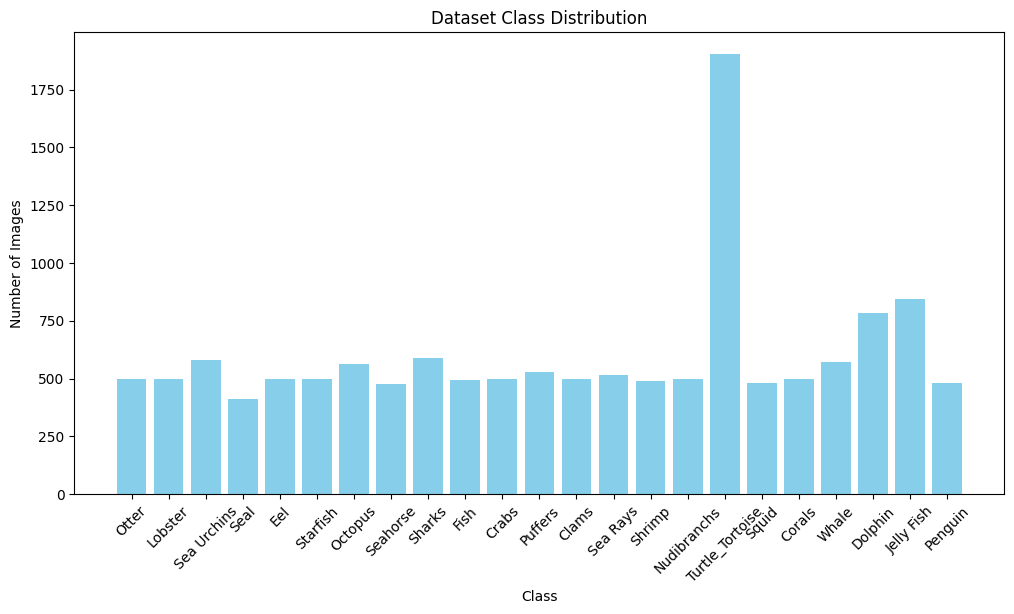

In [ ]:
# Show Sea Animal Image Dataset Distribution
dataset_path = '/content/dataset'
class_counts = {}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Dataset Class Distribution")
plt.show()

In [ ]:
# Display Crabs Image Resolution
class_name = "Crabs"

class_path = os.path.join(dataset_path, class_name)

if os.path.isdir(class_path):
    image_resolutions = {}

    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)

        if image is not None:
            height, width, _ = image.shape
            resolution = (width, height)

            if resolution in image_resolutions:
                image_resolutions[resolution] += 1
            else:
                image_resolutions[resolution] = 1

    # Show Result
    print(f"Resolution Distribution For Class: {class_name}")
    for res, count in image_resolutions.items():
        print(f"Resolution {res}: {count} Images")
else:
    print(f"Class '{class_name}' Not Found In Dataset.")

Resolution Distribution For Class: Crabs
Resolution (300, 225): 161 Images
Resolution (300, 200): 152 Images
Resolution (300, 195): 3 Images
Resolution (300, 295): 1 Images
Resolution (300, 199): 23 Images
Resolution (248, 300): 1 Images
Resolution (300, 241): 1 Images
Resolution (300, 169): 7 Images
Resolution (300, 209): 3 Images
Resolution (300, 197): 2 Images
Resolution (300, 300): 8 Images
Resolution (300, 218): 2 Images
Resolution (300, 170): 1 Images
Resolution (300, 210): 1 Images
Resolution (300, 182): 2 Images
Resolution (300, 201): 16 Images
Resolution (300, 222): 2 Images
Resolution (300, 174): 1 Images
Resolution (225, 300): 3 Images
Resolution (300, 217): 3 Images
Resolution (300, 140): 1 Images
Resolution (300, 237): 2 Images
Resolution (300, 227): 1 Images
Resolution (293, 300): 1 Images
Resolution (300, 214): 7 Images
Resolution (300, 207): 2 Images
Resolution (300, 213): 4 Images
Resolution (300, 164): 1 Images
Resolution (300, 189): 2 Images
Resolution (300, 224): 2 

### Data Preprocessing

In [ ]:
# Delete Unnecessary Class
merged_path = "/content/dataset"

classes_to_remove = [
    "Jelly Fish", "Seal", "Whale", "Corals", "Sea Rays", "Otter",
    "Octopus", "Squid", "Clams", "Nudibranchs"
]

for class_name in classes_to_remove:
    class_path = os.path.join(merged_path, class_name)
    if os.path.exists(class_path):
        shutil.rmtree(class_path)
        print(f"{class_name} Deleted.")

Jelly Fish Deleted.
Seal Deleted.
Whale Deleted.
Corals Deleted.
Sea Rays Deleted.
Otter Deleted.
Octopus Deleted.
Squid Deleted.
Clams Deleted.
Nudibranchs Deleted.


In [ ]:
# Data Augmentation
dataset_path = "/content/dataset"
augmented_path = "/content/dataset_augmented"

# Create New Folder To Save Augmented Images
os.makedirs(augmented_path, exist_ok=True)

# Image Resolution Target
TARGET_SIZE = (224, 224)

# Augmentation Functions
def flip_up_down(img):
    return np.flipud(img).astype(np.uint8)

def add_brightness(img):
    return img_as_ubyte(adjust_gamma(img, gamma=1.5, gain=1))

def blur_image(img):
    return cv2.GaussianBlur(img, (9, 9), 0)

def sheared(img):
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="reflect")
    return img_as_ubyte(shear_image)

def warp_shift(img):
    transform = AffineTransform(translation=(0, 40))
    warp_image = warp(img, transform, mode="reflect")
    return img_as_ubyte(warp_image)

# Dictionary of Augmentation Techniques
transformations = {
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

skip_classes = ["Turtle_Tortoise", "Sharks"]

for class_name in os.listdir(dataset_path):
    if class_name in skip_classes:
        print(f"Skipping Augmentation for Class: {class_name}")
        continue

    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):
        print(f"Processing Class: {class_name}")

        augmented_class_path = os.path.join(augmented_path, class_name)
        os.makedirs(augmented_class_path, exist_ok=True)
        images = [os.path.join(class_path, im) for im in os.listdir(class_path) if im.lower().endswith(('.jpg', '.png', '.jpeg'))]

        # Generate 500 Augmented Images
        images_to_generate = 500
        i = 1
        while i <= images_to_generate:
            image = random.choice(images)
            try:
                original_image = io.imread(image)

                if original_image is None or original_image.size == 0:
                    print(f"Skipping empty image: {image}")
                    continue

                transformed_image = original_image.copy()
                transformation_count = random.randint(1, len(transformations))

                for _ in range(transformation_count):
                    key = random.choice(list(transformations.keys()))
                    transformed_image = transformations[key](transformed_image)

                transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)

                # Save Augmented Image
                new_image_path = os.path.join(augmented_class_path, f"augmented_image_{i}.jpg")
                cv2.imwrite(new_image_path, transformed_image)
                i += 1

            except Exception as e:
                print(f'Error Processing {image}: {e}')

Processing Class: Lobster
Processing Class: Sea Urchins
Processing Class: Eel
Processing Class: Starfish
Processing Class: Seahorse
Skipping Augmentation for Class: Sharks
Processing Class: Fish
Processing Class: Crabs
Processing Class: Puffers
Processing Class: Shrimp
Skipping Augmentation for Class: Turtle_Tortoise
Processing Class: Dolphin
Processing Class: Penguin


In [ ]:
# Combine Original Image With Augmented Image
dataset_path = "/content/dataset"
augmented_path = "/content/dataset_augmented"
merged_path = "/content/dataset_merged"

# Create New Folder For Merge Dataset Folder
os.makedirs(merged_path, exist_ok=True)

# Function To Combine The Image
def merge_datasets(source_path, destination_path):
    for class_name in os.listdir(source_path):
        class_path = os.path.join(source_path, class_name)
        dest_class_path = os.path.join(destination_path, class_name)

        if os.path.isdir(class_path):
            os.makedirs(dest_class_path, exist_ok=True)

            for img in os.listdir(class_path):
                shutil.copy(os.path.join(class_path, img), os.path.join(dest_class_path, img))

merge_datasets(dataset_path, merged_path)
merge_datasets(augmented_path, merged_path)

In [ ]:
# Show The Total Of The Image
remaining_classes = [d for d in os.listdir(merged_path) if os.path.isdir(os.path.join(merged_path, d))]
total_images = 0

for class_name in remaining_classes:
    class_path = os.path.join(merged_path, class_name)
    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    print(f"{class_name}: {num_images} images")
    total_images += num_images

print(f"Total Images After Deletion: {total_images}")

Lobster: 999 images
Sea Urchins: 1079 images
Eel: 997 images
Starfish: 999 images
Seahorse: 978 images
Sharks: 590 images
Fish: 994 images
Crabs: 999 images
Puffers: 1031 images
Shrimp: 988 images
Turtle_Tortoise: 1903 images
Dolphin: 1282 images
Penguin: 982 images
Total Images After Deletion: 13821


In [ ]:
merged_path = "/content/dataset_merged"

undersampling_limits = {
    "Turtle_Tortoise": 1000,
    "Dolphin": 1000,
}

remaining_classes = [d for d in os.listdir(merged_path) if os.path.isdir(os.path.join(merged_path, d))]
total_images = 0

for class_name in remaining_classes:
    class_path = os.path.join(merged_path, class_name)
    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    print(f"{class_name}: {num_images} images")
    total_images += num_images

print(f"\nTotal Images Before Undersampling: {total_images}\n")

for class_name, limit in undersampling_limits.items():
    class_path = os.path.join(merged_path, class_name)

    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        num_images = len(images)

        if num_images > limit:
            print(f"Undersampling {class_name}: Reducing From {num_images} To {limit}")
            images_to_delete = random.sample(images, num_images - limit)

            for img in images_to_delete:
                os.remove(os.path.join(class_path, img))

total_images_after = 0
print("\nTotal Images After Undersampling:")
for class_name in remaining_classes:
    class_path = os.path.join(merged_path, class_name)
    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    print(f"{class_name}: {num_images} images")
    total_images_after += num_images

print(f"\nTotal Images After Undersampling: {total_images_after}")

Lobster: 999 images
Sea Urchins: 1079 images
Eel: 997 images
Starfish: 999 images
Seahorse: 978 images
Sharks: 590 images
Fish: 994 images
Crabs: 999 images
Puffers: 1031 images
Shrimp: 988 images
Turtle_Tortoise: 1903 images
Dolphin: 1282 images
Penguin: 982 images

Total Images Before Undersampling: 13821

Undersampling Turtle_Tortoise: Reducing From 1903 To 1000
Undersampling Dolphin: Reducing From 1282 To 1000

Total Images After Undersampling:
Lobster: 999 images
Sea Urchins: 1079 images
Eel: 997 images
Starfish: 999 images
Seahorse: 978 images
Sharks: 590 images
Fish: 994 images
Crabs: 999 images
Puffers: 1031 images
Shrimp: 988 images
Turtle_Tortoise: 1000 images
Dolphin: 1000 images
Penguin: 982 images

Total Images After Undersampling: 12636


In [ ]:
# Show The Image Resolution
def print_images_resolution(directory):
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue

        unique_sizes = set()
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images} images")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal images: {total_images}")

print_images_resolution("/content/dataset_merged")

Lobster: 999 images
- (300, 206)
- (210, 300)
- (289, 300)
- (199, 300)
- (300, 209)
- (300, 282)
- (300, 221)
- (300, 166)
- (300, 224)
- (300, 169)
- (300, 233)
- (201, 300)
- (300, 236)
- (300, 181)
- (300, 300)
- (300, 187)
- (203, 300)
- (225, 300)
- (300, 251)
- (240, 300)
- (300, 199)
- (300, 257)
- (300, 202)
- (300, 208)
- (853, 640)
- (300, 205)
- (300, 211)
- (300, 214)
- (300, 220)
- (300, 217)
- (300, 168)
- (300, 226)
- (300, 232)
- (300, 229)
- (299, 300)
- (300, 238)
- (200, 300)
- (300, 183)
- (300, 189)
- (300, 186)
- (771, 640)
- (300, 192)
- (300, 250)
- (300, 195)
- (300, 201)
- (300, 198)
- (300, 207)
- (300, 213)
- (300, 210)
- (300, 216)
- (300, 219)
- (300, 225)
- (261, 300)
- (215, 300)
- (206, 300)
- (960, 640)
- (300, 292)
- (300, 298)
- (300, 237)
- (300, 231)
- (300, 295)
- (300, 240)
- (300, 246)
- (300, 185)
- (300, 188)
- (300, 194)
- (300, 200)
---------------
Sea Urchins: 1079 images
- (300, 206)
- (199, 300)
- (278, 300)
- (300, 215)
- (300, 209)
- (

In [ ]:
# Prepare Dataset Path For Train, Val and Test
data_dir = '/content/dataset_merged'
train_dir = '/content/datasets/train'
val_dir = '/content/datasets/val'
test_dir = '/content/datasets/test'

In [ ]:
# Split Dataset
test_ratio = 0.15
val_ratio = 0.15

# Define New Class Mapping
class_mapping = {
    "Crustacea": ["Crabs", "Lobster", "Shrimp"],
    "Pisces": ["Sharks", "Seahorse", "Puffers", "Eel", "Fish"],
    "Vertebrata": ["Turtle_Tortoise", "Dolphin", "Penguin"],
    "Echinodermata": ["Starfish", "Sea Urchins"],
}

# Function to Validate Images
def is_valid_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()
        return True
    except:
        return False

# Reset Dataset Directories
for folder in [train_dir, val_dir, test_dir]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder, exist_ok=True)

# Create Class Directories
for new_class in class_mapping.keys():
    for folder in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(folder, new_class), exist_ok=True)

# Process Dataset
for new_class, old_classes in class_mapping.items():
    images = []

    # Gather Images from Old Classes
    for old_class in old_classes:
        class_path = os.path.join(data_dir, old_class)
        if os.path.isdir(class_path):
            valid_images = [os.path.join(class_path, img) for img in os.listdir(class_path) if is_valid_image(os.path.join(class_path, img))]
            images.extend(valid_images)

    print(f"Processing {new_class}: Found {len(images)} images")

    # Split Data
    train_imgs, test_imgs = train_test_split(images, test_size=test_ratio, random_state=42)
    train_imgs, val_imgs = train_test_split(train_imgs, test_size=val_ratio / (1 - test_ratio), random_state=42)

    def copy_images(image_list, dst_folder):
        for img_path in image_list:
            shutil.copy(img_path, os.path.join(dst_folder, os.path.basename(img_path)))

    copy_images(train_imgs, os.path.join(train_dir, new_class))
    copy_images(val_imgs, os.path.join(val_dir, new_class))
    copy_images(test_imgs, os.path.join(test_dir, new_class))

    print(f"✔ {new_class} -> Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

print("Dataset Successfully Regrouped!")

Processing Crustacea: Found 2986 images
✔ Crustacea -> Train: 2090, Val: 448, Test: 448
Processing Pisces: Found 4590 images
✔ Pisces -> Train: 3212, Val: 689, Test: 689
Processing Vertebrata: Found 2982 images
✔ Vertebrata -> Train: 2086, Val: 448, Test: 448
Processing Echinodermata: Found 2078 images
✔ Echinodermata -> Train: 1454, Val: 312, Test: 312
Dataset Successfully Regrouped!


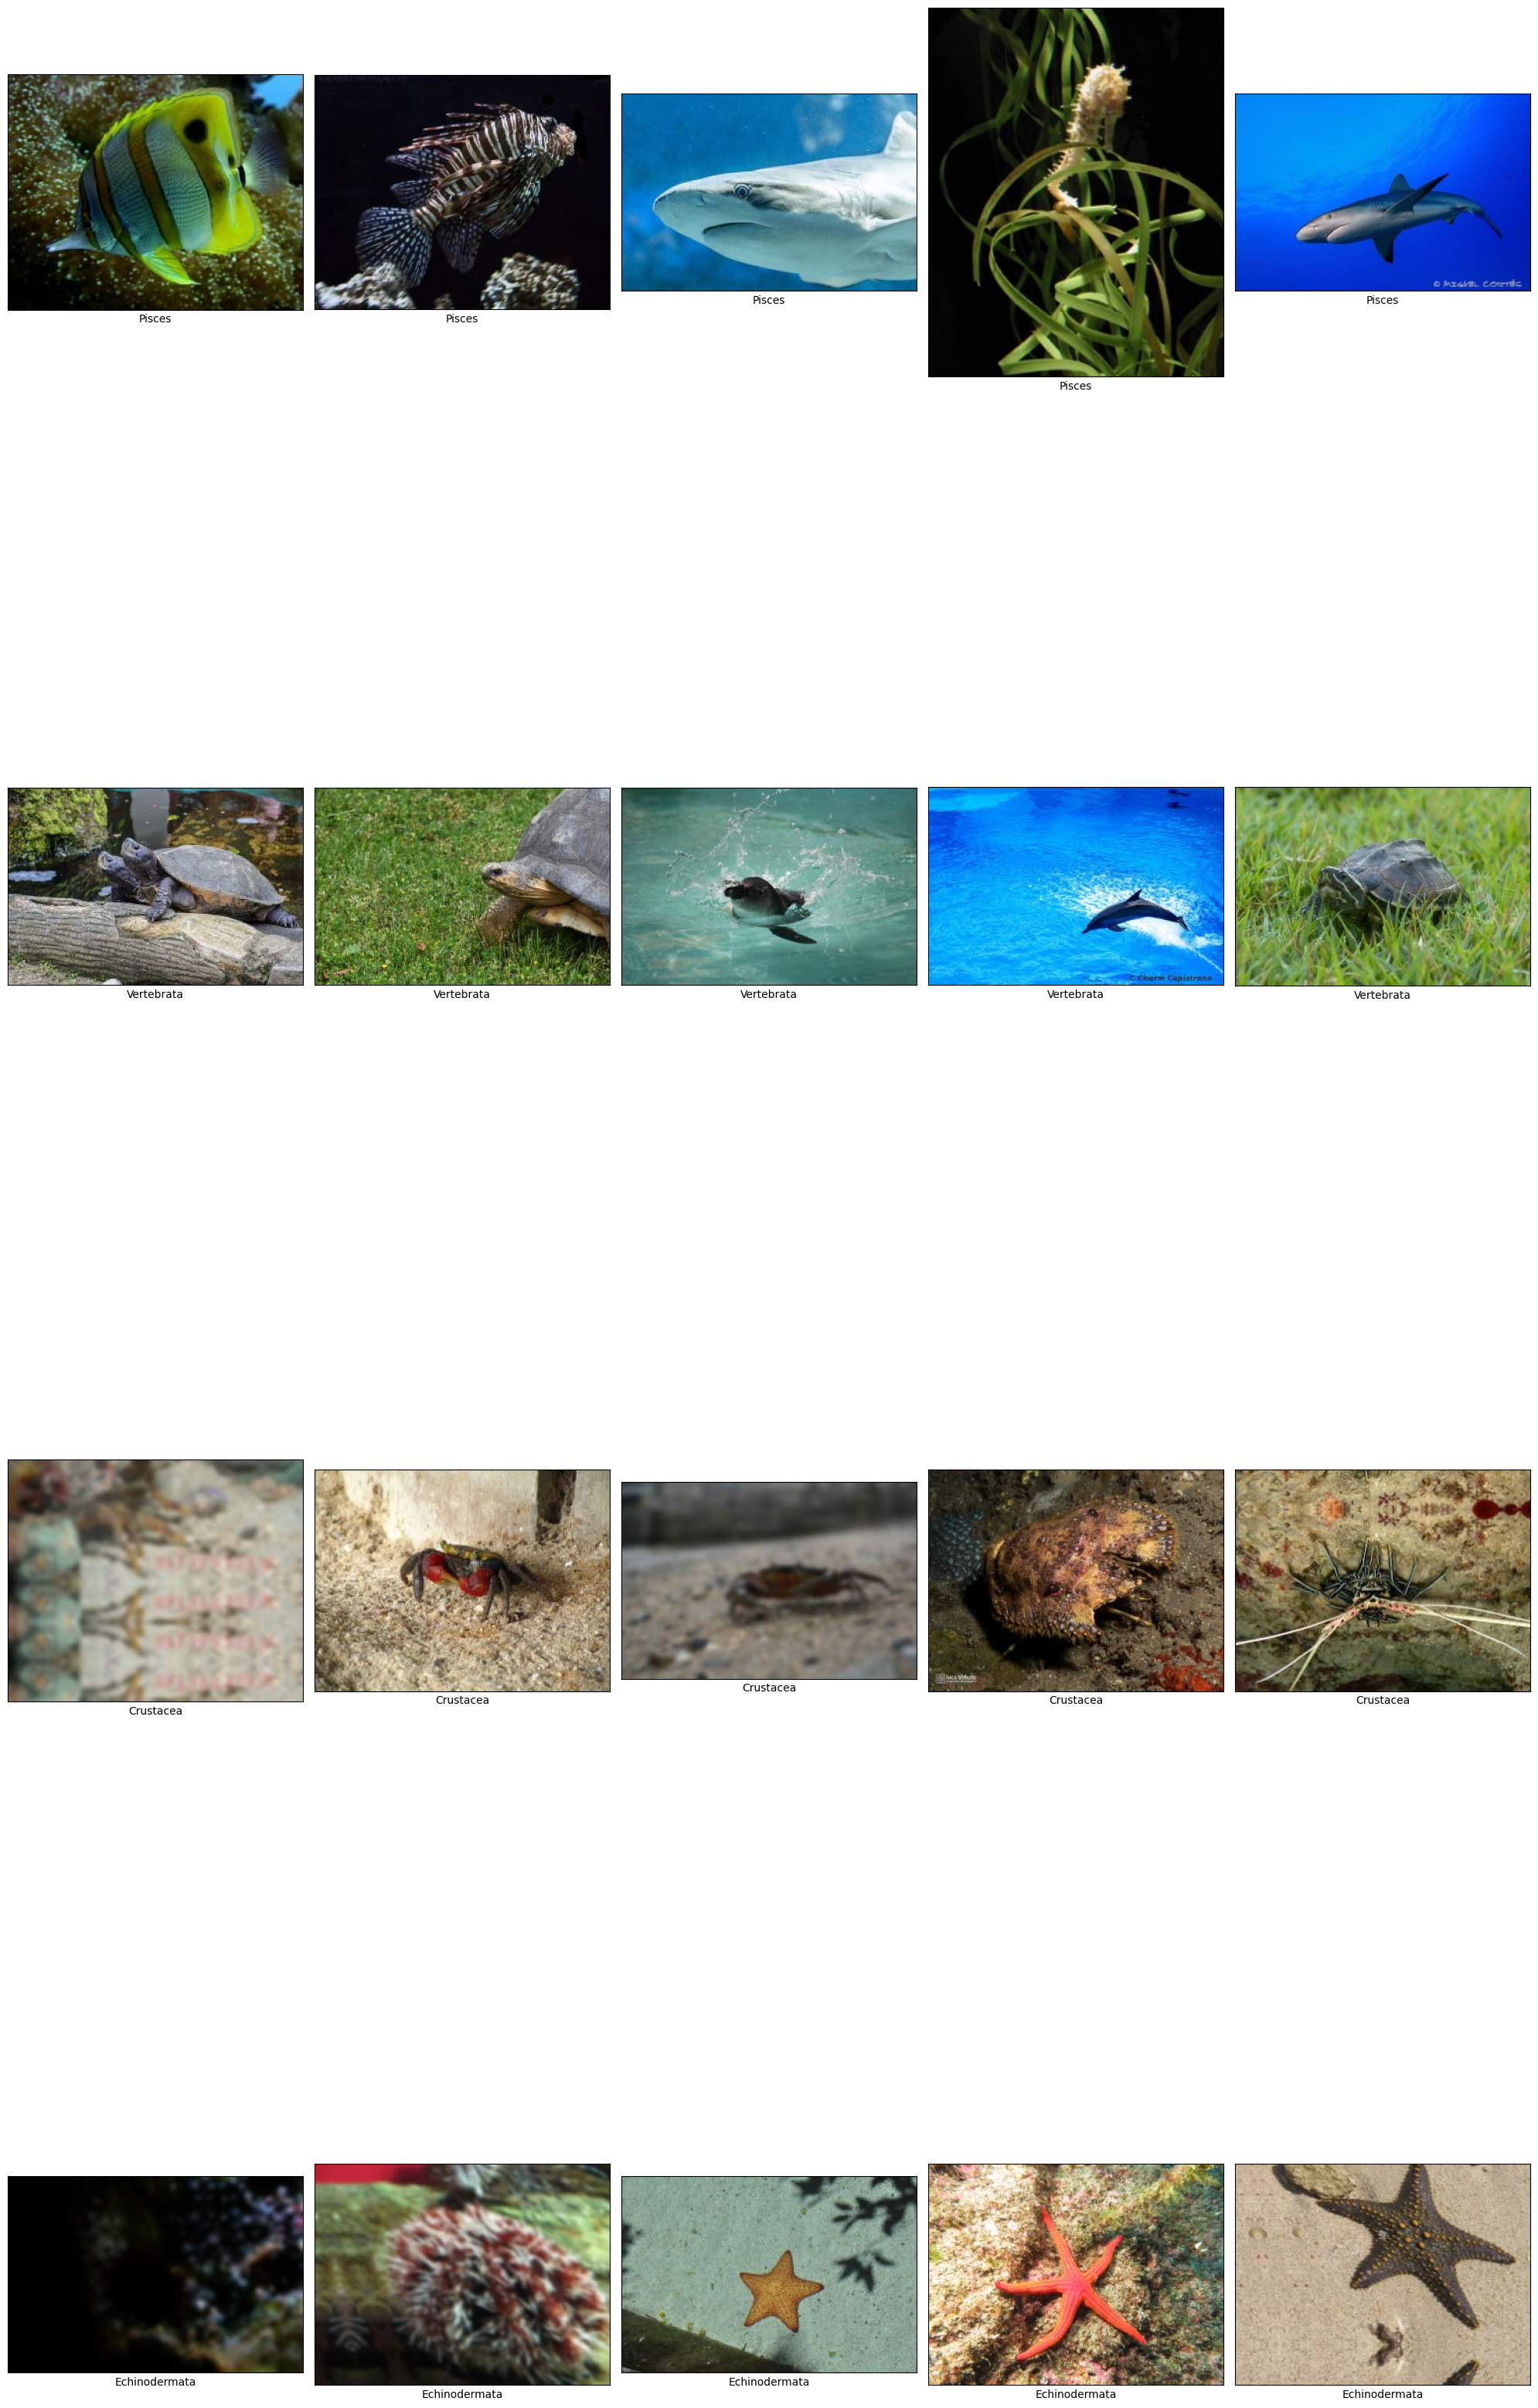

In [ ]:
sea_animal_images = {}

path_sub = train_dir
for class_name in os.listdir(path_sub):
    class_path = os.path.join(path_sub, class_name)
    if os.path.isdir(class_path):
        sea_animal_images[class_name] = os.listdir(class_path)

num_classes_to_show = 5
num_images_per_class = 5

selected_classes = random.sample(list(sea_animal_images.keys()), min(num_classes_to_show, len(sea_animal_images)))
fig, axs = plt.subplots(len(selected_classes), num_images_per_class, figsize=(20, 40))

for i, class_name in enumerate(selected_classes):
    images = random.sample(sea_animal_images[class_name], min(num_images_per_class, len(sea_animal_images[class_name])))

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("RGB")
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescale For Val & Test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=1,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 6959 images belonging to 4 classes.
Found 1772 images belonging to 4 classes.
Found 1782 images belonging to 4 classes.


In [ ]:
import os

def count_images_in_folder(folder_path):
    total_images = 0
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
            print(f"{class_name}: {num_images} images")
            total_images += num_images
    print(f"Total images in {folder_path}: {total_images}")

print("Checking Training Set:")
count_images_in_folder(train_dir)

print("\nChecking Validation Set:")
count_images_in_folder(val_dir)

print("\nChecking Test Set:")
count_images_in_folder(test_dir)

Checking Training Set:
Crustacea: 1543 images
Vertebrata: 1890 images
Echinodermata: 1220 images
Pisces: 2306 images
Total images in /content/datasets/train: 6959

Checking Validation Set:
Crustacea: 413 images
Vertebrata: 438 images
Echinodermata: 298 images
Pisces: 623 images
Total images in /content/datasets/val: 1772

Checking Test Set:
Crustacea: 417 images
Vertebrata: 441 images
Echinodermata: 300 images
Pisces: 624 images
Total images in /content/datasets/test: 1782


## Modelling

In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,972 (9.87 MB)

 Trainable params: 2,184,580 (8.33 MB)

 Non-trainable params: 403,392 (1.54 MB)

In [ ]:
# Model Complile
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks For Early Stopping & Learning Rate
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)

class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97:
            print("\nReached 97% training accuracy & 97% validation accuracy! Stopping training...")
            self.model.stop_training = True

# Training Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, reduce_lr, StopTrainingCallback()]
)

Epoch 1/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 143s 550ms/step - accuracy: 0.9397 - loss: 0.4758 - val_accuracy: 0.9345 - val_loss: 0.5021 - learning_rate: 1.0000e-04
Epoch 2/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 110s 506ms/step - accuracy: 0.9517 - loss: 0.4370 - val_accuracy: 0.9035 - val_loss: 0.6004 - learning_rate: 1.0000e-04
Epoch 3/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 110s 503ms/step - accuracy: 0.9491 - loss: 0.4172 - val_accuracy: 0.9221 - val_loss: 0.5683 - learning_rate: 1.0000e-04
Epoch 4/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 108s 495ms/step - accuracy: 0.9591 - loss: 0.3770 - val_accuracy: 0.9413 - val_loss: 0.4759 - learning_rate: 3.0000e-05
Epoch 5/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 109s 500ms/step - accuracy: 0.9662 - loss: 0.3627 - val_accuracy: 0.9391 - val_loss: 0.4818 - learning_rate: 3.0000e-05
Epoch 6/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 111s 508ms/step - accuracy: 0.9630 - loss: 0.3614 - val_accuracy: 0.9470 - val_loss: 0.4545 - learning_rate: 3.0000e-05
Epoch 7/100
218/218 ━━━━━━━━━━━━━━

## Evaluasi dan Visualisasi

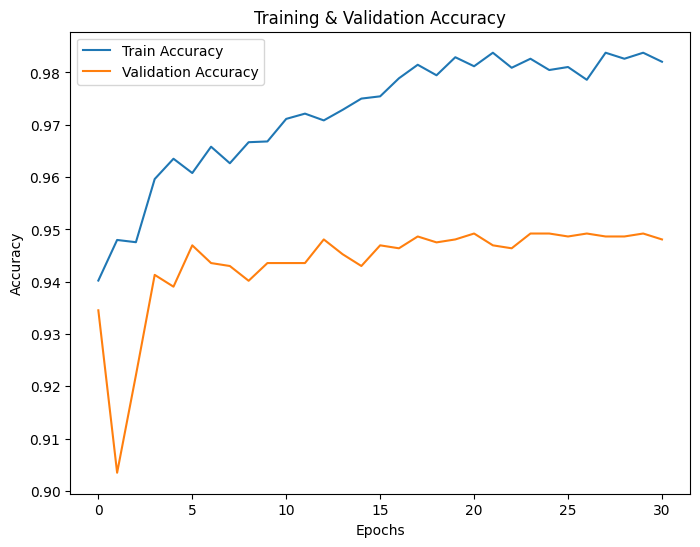

In [ ]:
# Training & Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

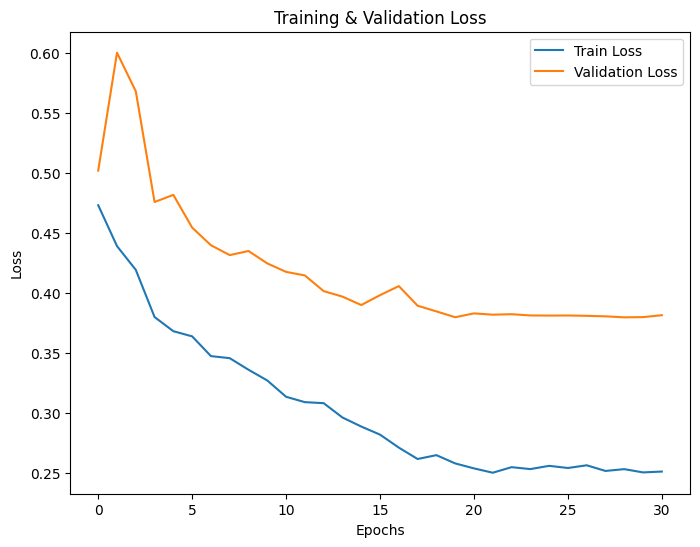

In [ ]:
# Training & Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

In [ ]:
# Prediction For Test Set
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

1782/1782 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step


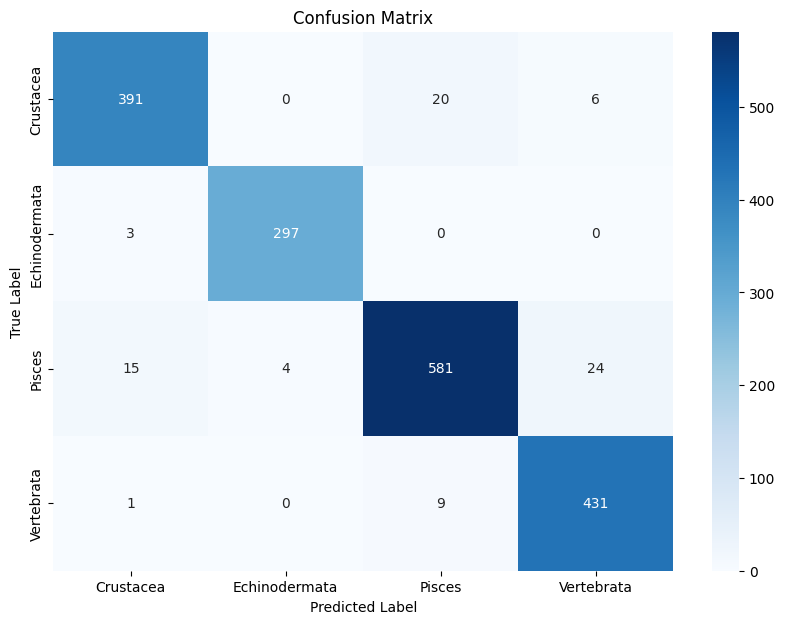

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

Classification Report:
               precision    recall  f1-score   support

    Crustacea       0.95      0.94      0.95       417
Echinodermata       0.99      0.99      0.99       300
       Pisces       0.95      0.93      0.94       624
   Vertebrata       0.93      0.98      0.96       441

     accuracy                           0.95      1782
    macro avg       0.96      0.96      0.96      1782
 weighted avg       0.95      0.95      0.95      1782



# **MODEL CONVERTION**

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 27.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.regularizers import l2
import numpy as np

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    Dense(len(train_generator.class_indices), activation='softmax')
])

sample_input = np.random.random((1, 224, 224, 3))
model(sample_input)

model.export("exported_model")

reloaded_artifact = tf.saved_model.load("exported_model")

input_data = np.random.random((8, 224, 224, 3))
new_output_data = reloaded_artifact.serve(input_data)

print("Original model output shape:", model(input_data).shape)
print("Reloaded model output shape:", new_output_data.shape)

Saved artifact at 'exported_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_3068')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136587627267856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136587627273232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136587627273616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136587627273424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136587627269200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136587627274768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136587627275152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136587627275536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136587627275344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136587627272272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13658762727

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("/content/sea_animals_classification_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp7mswip5m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136589178348816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136589178350160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136589178350544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136589178350352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136589178349008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136589178351696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136589178352080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136589178352464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136589178352272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136589178349584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1365891783536

In [ ]:
import tensorflowjs as tfjs

!tensorflowjs_converter --input_format=keras sea_animals_classification_model.h5 tfjs_model

2025-03-01 10:45:51.137284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740825951.173379   27016 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740825951.179629   27016 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


## **INFERENCE**

Saving images.jpg to images.jpg
Predicted Class: Pisces (Accuracy: 52.90%)


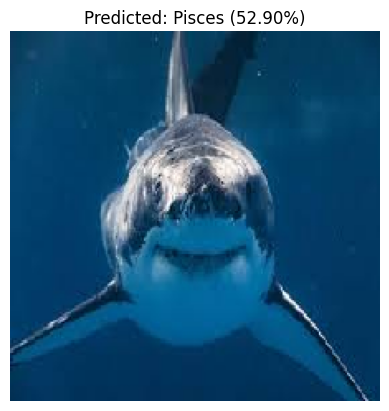

In [ ]:
from google.colab import files

uploaded = files.upload()
img_path = next(iter(uploaded))

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

interpreter = tf.lite.Interpreter(model_path="/content/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()
predictions = interpreter.get_tensor(output_details[0]['index'])

predicted_class = np.argmax(predictions, axis=1)[0]
accuracy = np.max(predictions) * 100

class_labels = ["Crustacea", "Echinodermata", "Pisces", "Vertebrata"]
predicted_label = class_labels[predicted_class]

print(f"Predicted Class: {predicted_label} (Accuracy: {accuracy:.2f}%)")

plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_label} ({accuracy:.2f}%)")
plt.show()

In [ ]:
!pip freeze > requirements.txt
!cat requirements.txt

absl-py==1.4.0
accelerate==1.3.0
aiohappyeyeballs==2.4.6
aiohttp==3.11.13
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.4
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.6.0
arviz==0.20.0
astropy==7.0.1
astropy-iers-data==0.2025.2.24.0.34.4
astunparse==1.6.3
atpublic==4.1.0
attrs==25.1.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.38.0
bigquery-magics==0.6.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==3.1.1
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.20.0
cloudpickle==3.1.1
cmake==3.31.4
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.